In [1]:
import numpy as np
import pandas as pd
import itertools
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from IPython.display import SVG
from keras.utils import plot_model

warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
filename = '/kaggle/input/wheatdatafix/wheatdatafix.xlsx'
STORAGE_FOLDER = ''

In [3]:
wheatdata = pd.read_excel(filename)
wheatdata = wheatdata['Food use']
wheatdata = pd.DataFrame({'data':wheatdata})
dates = pd.date_range(start='1950-01', freq='AS', periods=len(wheatdata))
wheatdata.set_index(dates, inplace=True)

Text(0.5,1,'Year vs Food Use across all years')

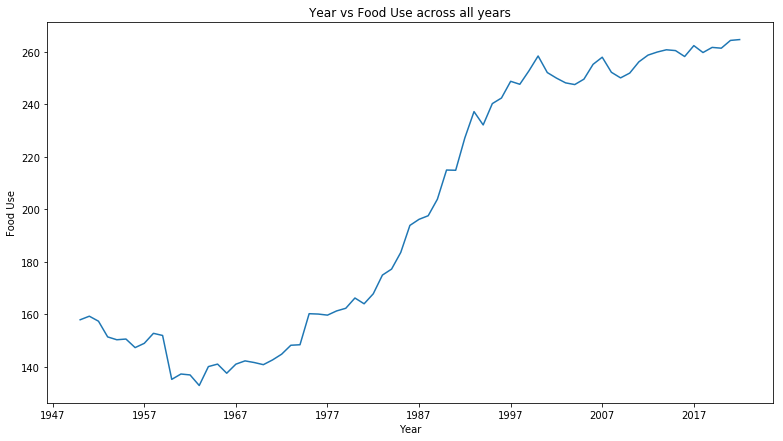

In [4]:
plt.figure(figsize=(13,7))
plt.plot(wheatdata)
plt.xlabel('Year')
plt.ylabel('Food Use')
plt.title('Year vs Food Use across all years')

In [5]:
test_wheatdata = wheatdata.loc['2002': '2022']
wheatdata = wheatdata.loc[: '2001']
wheatdata = wheatdata.round(5)
print(len(test_wheatdata),len(wheatdata))

21 52


In [6]:
wheatdata.shape

(52, 1)

In [7]:
test_wheatdata.shape

(21, 1)

In [8]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(wheatdata)

MinMaxScaler(copy=True, feature_range=(0, 1))

### Functions required

In [9]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def root_mean_squared_error(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return rmse

In [10]:
def calculate_performance(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    return round(mse, 3), round(mae, 3), round(mape, 3), round(rmse, 3)

In [11]:
def plot_keras_model(model, show_shapes=True, show_layer_names=True):
    return SVG(model_to_dot(model, show_shapes=show_shapes, show_layer_names=show_layer_names).create(prog='dot',format='svg'))

In [12]:
def get_combinations(parameters):
    return list(itertools.product(*parameters))

### Create a Neural Network

In [13]:
def create_NN(input_nodes, hidden_nodes, output_nodes):
    model = Sequential()
    model.add(Dense(int(hidden_nodes), input_dim=int(input_nodes)))
    model.add(Dense(int(output_nodes)))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

### Train model

In [14]:
def train_model(model, X_train, y_train, epochs, batch_size):
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=True)
    return model

In [15]:
def reshape_arrays(X_train, y_train):
    X_train = np.array(X_train)
    y_train = np.reshape(y_train, (len(y_train), 1))
    return X_train, y_train

### SANN - Preprocess data: Convert time series into suitable format

In [16]:
def preprocess_SANN(data, seasonal_period):
    data = np.array(data)[:, 0]
    X_train = []
    y_train = []
    for i in range(seasonal_period, data.shape[0]-seasonal_period+1):
        x = data[i-seasonal_period:i][::-1]
        y = data[i:i+seasonal_period]
        X_train.append(list(x))
        y_train.append(list(y))
    input_seq_for_test = data[i+1-seasonal_period:i+1][::-1]
    return X_train, y_train, input_seq_for_test

### SANN - Forecast next 'n' timesteps

In [17]:
def forecast_SANN(model, input_sequence, seasonal_period, future_steps):
    iterations = future_steps/seasonal_period
    forecasted_values = []
    for i in range(int(iterations) + 1):
        next_forecasted_values = model.predict(input_sequence)
        forecasted_values += list(next_forecasted_values[0])
        input_sequence = next_forecasted_values
    return forecasted_values[:future_steps]

### Seasonal Artificial  Neural Networks

In [18]:
def SANN(data, seasonal_period, hidden_nodes, epochs, batch_size, future_steps, scaler):
    data = scaler.transform(data)
    X_train, y_train, input_seq_for_test_SANN = preprocess_SANN(data, seasonal_period)
    X_train = np.array(X_train)
    y_train = np.array(y_train)

    input_seq_for_test_SANN = np.reshape(input_seq_for_test_SANN, (1, len(input_seq_for_test_SANN)))
    model_SANN = create_NN(input_nodes=seasonal_period, hidden_nodes=hidden_nodes, output_nodes=seasonal_period)
    model_SANN = train_model(model_SANN, X_train, y_train, epochs, batch_size)
    
    forecasted_values_SANN = forecast_SANN(model_SANN, input_seq_for_test_SANN, seasonal_period, future_steps=future_steps)
    forecasted_values_SANN = list(scaler.inverse_transform([forecasted_values_SANN])[0])
    return model_SANN, forecasted_values_SANN

### SANN - Get scores on test data

In [19]:
def get_accuracies_SANN(rainfall_data, test_rainfall_data, parameters, scaler):
    combination_of_params = get_combinations(parameters)
    information_SANN = []
    iterator = 0
    print('SANN - Number of combinations: ' + str(len(combination_of_params)))
    
    for param in combination_of_params:
        if (iterator+1) != len(combination_of_params):
            print(iterator+1, end=' -> ')
        else:
            print(iterator+1)
        iterator = iterator+1

        seasonal_period = param[0]
        hidden_nodes = param[1]
        epochs = param[2]
        batch_size = param[3]
        future_steps = param[4]

        model_SANN, forecasted_values_SANN = SANN(rainfall_data, seasonal_period, hidden_nodes, epochs, batch_size, future_steps, scaler)
        
        y_true = test_rainfall_data.iloc[:future_steps].data
        mse, mae, mape, rmse = calculate_performance(y_true, forecasted_values_SANN)
        
        info = list(param) + [mse, mae, rmse] + forecasted_values_SANN
        information_SANN.append(info)

    information_SANN_df = pd.DataFrame(information_SANN)
    indexes = [str(i) for i in list(range(1, future_steps+1))]
    information_SANN_df.columns = ['seasonal_period', 'hidden_nodes', 'epochs', 'batch_size', 'future_steps', 'MSE', 'MAE', 'RMSE'] + indexes
    return information_SANN_df

## Analyze the test data and forecasted data
- Plot the actual and forecasted values.
- Display optimal parameters.

In [20]:
def analyze_results(data_frame, test_rainfall_data, name, flag=False):
    optimized_params = data_frame.iloc[data_frame.RMSE.idxmin()]
    future_steps = optimized_params.future_steps
    forecast_values = optimized_params[-1*int(future_steps):]
    y_true = test_rainfall_data.iloc[:int(future_steps)]
    forecast_values.index = y_true.index
    
    print('=== Best parameters of ' + name + ' ===\n')
    if (name == 'SANN'):
        model = create_NN(optimized_params.seasonal_period, 
                          optimized_params.hidden_nodes, 
                          optimized_params.seasonal_period)
        print('Input nodes(s): ' + str(optimized_params.seasonal_period))
        print('Hidden nodes: ' + str(optimized_params.hidden_nodes))
        print('Output nodes: ' + str(optimized_params.seasonal_period))
        
    print('Number of epochs: ' + str(optimized_params.epochs))
    print('Batch size: ' + str(optimized_params.batch_size))
    print('Number of future steps forecasted: ' + str(optimized_params.future_steps))
    print('Mean Squared Error(MSE): ' + str(optimized_params.MSE))
    print('Mean Absolute Error(MAE): ' + str(optimized_params.MAE))
    print('Root Mean Squared Error(RMSE): ' + str(optimized_params.RMSE))
    print('\n\n')
    
    # Save model
    from keras.utils import plot_model
    plot_model(model, to_file = STORAGE_FOLDER + name + '_best_fit_model.png', show_shapes=True, show_layer_names=True)
    
    # Save data
    data_frame.to_csv(STORAGE_FOLDER + name + '_information.csv')
    optimized_params.to_csv(STORAGE_FOLDER + name + '_optimized_values.csv')
    
    plt.figure(figsize=(10,5))
    plt.plot(y_true, color='green', label='Actual values')
    plt.plot(forecast_values, color='red', label='Forecasted values')
    plt.xlabel('Year')
    plt.ylabel('Yearly mean Food Use')
    plt.legend(loc='best')
    if (flag==False):
        plt.title(name + ' - Comparison: Actual vs Forecasted')
        plt.savefig(STORAGE_FOLDER + name + '_best_forecast'  + '.png')
    else:
        plt.title('Best of all: ' + name + ' - Comparison: Actual vs Forecasted')
        plt.savefig(STORAGE_FOLDER + 'BEST_FORECAST_' + name + '.png')
    
    return optimized_params

In [21]:
def best(list_of_methods):
    RMSE_values = [x.RMSE for x in list_of_methods]
    index = np.argmin(RMSE_values)
    name = 'SANN'
    print(RMSE_values)
    8
    names = ['SANN']
    RMSE_info = pd.Series(RMSE_values, index=names)
    
    print('Overall Best method on this data is ' + name)
    return index, name, RMSE_info

In [22]:
def compare_ANN_methods(rainfall_data, test_rainfall_data, scaler, parameters_SANN, future_steps):
    
    information_SANN_df = get_accuracies_SANN(rainfall_data, test_rainfall_data, parameters_SANN, scaler)
    optimized_params_SANN = analyze_results(information_SANN_df, test_rainfall_data, 'SANN')
    
    list_of_methods = [optimized_params_SANN]
    information = [information_SANN_df]
    index, name, RMSE_info = best(list_of_methods)
    best_optimized_params = analyze_results(information[index], test_rainfall_data, name, True)
    return RMSE_info

In [23]:
future_steps = 21

SANN - Number of combinations: 8
1 -> 2 -> 3 -> 4 -> 5 -> 6 -> 7 -> 8
=== Best parameters of SANN ===

Input nodes(s): 12.0
Hidden nodes: 8.0
Output nodes: 12.0
Number of epochs: 500.0
Batch size: 20.0
Number of future steps forecasted: 21.0
Mean Squared Error(MSE): 421.089
Mean Absolute Error(MAE): 17.761
Root Mean Squared Error(RMSE): 20.52



[20.52]
Overall Best method on this data is SANN
=== Best parameters of SANN ===

Input nodes(s): 12.0
Hidden nodes: 8.0
Output nodes: 12.0
Number of epochs: 500.0
Batch size: 20.0
Number of future steps forecasted: 21.0
Mean Squared Error(MSE): 421.089
Mean Absolute Error(MAE): 17.761
Root Mean Squared Error(RMSE): 20.52





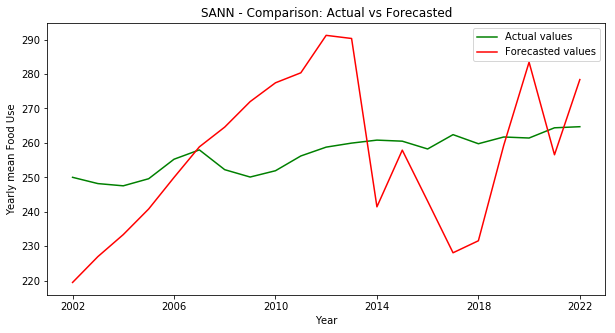

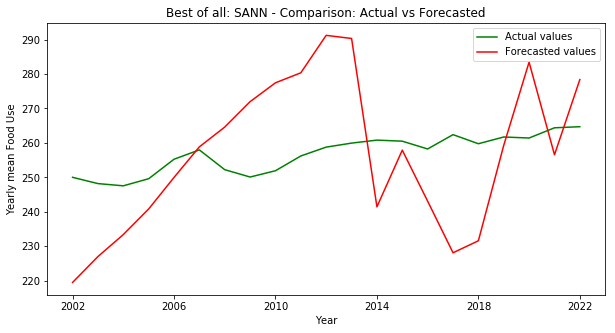

In [24]:
# seasonal_period, hidden_nodes, epochs, batch_size, future_steps
parameters_SANN = [[12], [3,4,5,6,7,8,9,10], [500], [20], [future_steps]]

RMSE_info = compare_ANN_methods(wheatdata, test_wheatdata, scaler, parameters_SANN, future_steps)

In [25]:
RMSE_info

SANN    20.52
dtype: float64

## Plot RMSE scores

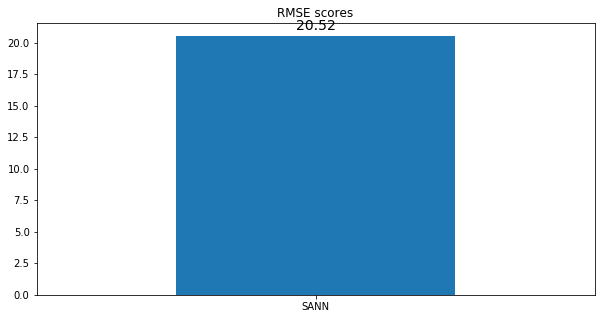

In [26]:
ax = RMSE_info.plot(kind='bar', figsize=(10,5), rot=0, title='RMSE scores')

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', va='center', xytext=(0, 10), 
                textcoords='offset points', fontsize=14, color='black')